In [39]:
import glob
from pathlib import Path

import random

import numpy as np
from numba import njit

from PIL import Image
from matplotlib import pyplot as plt

In [40]:
@njit(fastmath=True)
def convolve(X: np.ndarray, W: np.ndarray):
    A = np.zeros((X.shape[0]-1, X.shape[1]-1))
    for i in range(X.shape[0]-1):
        for j in range(X.shape[1]-1):
            A[i][j] = np.sum(X[i:i+2, j:j+2]*W[i][j])
    return A


@njit(fastmath=True)
def update(S: np.ndarray, W: np.ndarray, X: np.ndarray, p: float, a: float, b: float):
    A = np.zeros(S.shape)
    for i in range(S.shape[0]-1):
        for j in range(S.shape[1]-1):
            A[i:i+2, j:j+2] += X[i:i+2, j:j+2]*W[i][j]

    newW = np.zeros(W.shape)
    for i in range(S.shape[0]-1):
        for j in range(S.shape[1]-1):
            newW[i][j] = a*W[i][j]+b*(X[i:i+2, j:j+2]-S[i:i+2, j:j+2])

    return p*S+A, newW


class ConvolutionFadeMemoryNN:
    def __init__(self, mem_shape: tuple, p: float, a: float, b: float) -> None:
        self.s: np.ndarray = np.zeros(mem_shape)
        self.w: np.ndarray = np.array([[np.full((2, 2), 1e-6) for i in range((mem_shape[0]-1))]
                                       for j in range(mem_shape[1]-1)])

        self.p = p
        self.a = a
        self.b = b

    def update(self, X: np.ndarray):
        self.s, self.w = update(
            self.s, self.w, X, self.p, self.a, self.b)
        np.clip(self.s, MIN_S, MAX_S)

    def predict(self, X: np.ndarray):
        return convolve(X, self.w)

In [41]:
def load_images(path: Path) -> list[np.ndarray]:
    files = glob.glob(path.as_posix())
    images = []
    for f in files:
        img = Image.open(f).convert('L')
        img.thumbnail(MEMSHAPE, Image.Resampling.LANCZOS)
        img = np.array(img).transpose().astype('float')
        images.append(img/np.max(img))
    return images


def recunstruct_mem(cfmnn: ConvolutionFadeMemoryNN):
    r = np.zeros(cfmnn.s.shape)
    for i in range(cfmnn.s.shape[0]-1):
        for j in range(cfmnn.s.shape[1]-1):
            r[i:i+2, j:j+2] += cfmnn.w[i][j]
    return r.transpose()

In [42]:
images = load_images(Path('..', '..', 'data', 'images', 'numbers', '*'))

In [120]:
N = 32
MEMSHAPE = (N, N)

MIN_S = -1e3
MAX_S = 1e3
P = 0.95
ALPHA = 0.9
BETA = 1e-3

RND_THRESHOLD = 1
MIN_W = -1
MAX_W = 1

NOISE = 0.5

In [121]:
cfmnn = ConvolutionFadeMemoryNN(MEMSHAPE, P, ALPHA, BETA)

for k in range(10):
    for i in np.random.permutation(10):
        cfmnn.update(images[i] + np.random.uniform(-NOISE, NOISE, MEMSHAPE))

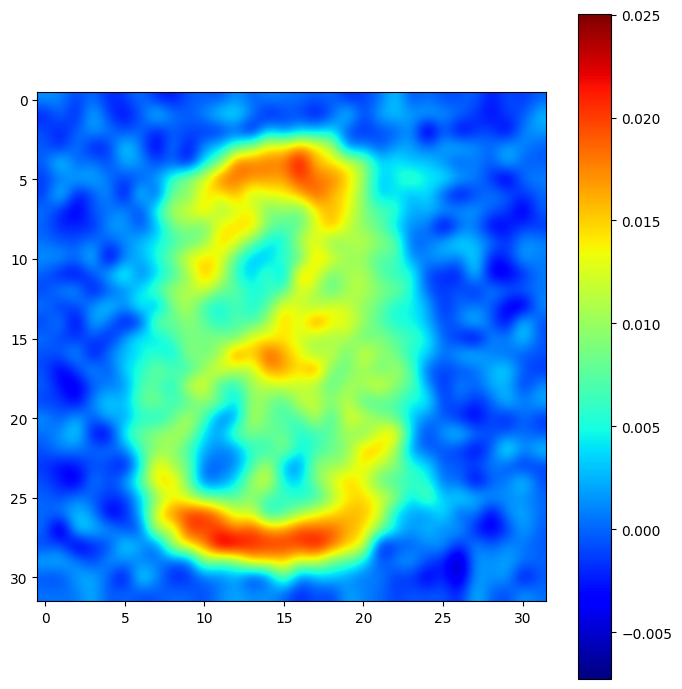

In [122]:
fig1, axes1 = plt.subplots(1, figsize=(7, 7), dpi=100)

img = axes1.imshow(recunstruct_mem(cfmnn), cmap='jet', interpolation='bicubic')

plt.colorbar(img)

plt.tight_layout()
plt.show()

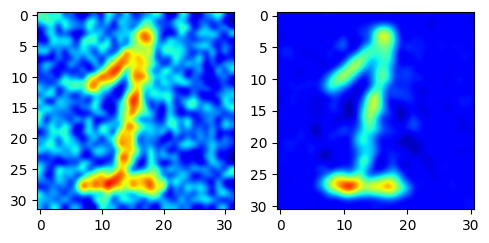

In [123]:
fig2, axes2 = plt.subplots(nrows=1, ncols=2)
fig2.set_figwidth(5)
fig2.set_figheight(5)
fig2.set_dpi(100)

img = images[1] + np.random.uniform(-NOISE, NOISE, MEMSHAPE)

res = cfmnn.predict(img).transpose()
        
axes2[0].imshow(
    img.transpose(),
    cmap='jet',
    interpolation='bicubic'
)

axes2[1].imshow(
    res,
    cmap='jet',
    interpolation='bicubic'
)

plt.tight_layout()
plt.show()

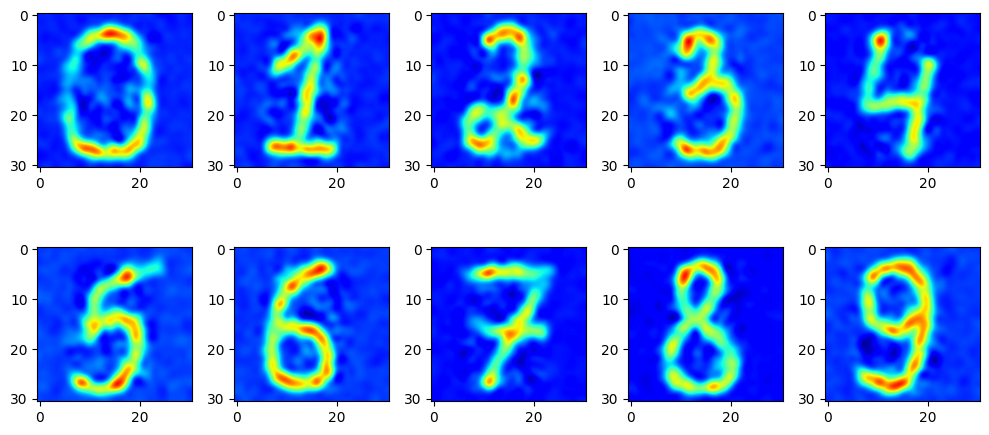

In [99]:
fig3, axes3 = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), dpi=100)

for i,ax in enumerate(axes3.ravel()):
        img = images[i] + np.random.uniform(-NOISE, NOISE, MEMSHAPE)
        
        res = cfmnn.predict(img).transpose()
        
        ax.imshow(
            res/np.max(res),
            cmap='jet',
            interpolation='bicubic'
        )

plt.tight_layout()
plt.show()